# ***Tarea 3. Comparación de Modelos***


**Dora Alicia Guevara Villalpando**  
**Procesamiento y clasificación de datos**  



**Requerimientos:**

1. Selección del conjunto de datos.
2. Método de vectorización.
3. Preprocesamiento: limpieza de texto (remoción de stop words, stemming, etc.), tokenización, y más.
4. Modelos de clasificación de texto.
5. Reporte.


## **Cargar el conjunto de datos.**

### **Conjunto de Datos: *IMDB Movie Reviews***  


**Visión General**  
Este conjunto de datos contiene reseñas de películas junto con sus etiquetas de polaridad de sentimiento binario asociadas. Está diseñado para servir como referencia en la clasificación de sentimientos. Este documento describe cómo se recopiló el conjunto de datos y cómo utilizar los archivos proporcionados.  


**Conjunto de Datos**  
El conjunto de datos principal contiene 50,000 reseñas, divididas equitativamente en 25,000 para entrenamiento y 25,000 para prueba. La distribución general de etiquetas está equilibrada (25,000 positivas y 25,000 negativas). Además, se incluyen 50,000 documentos adicionales sin etiquetas para el aprendizaje no supervisado.

En toda la colección, no se permiten más de 30 reseñas para una misma película, ya que las reseñas del mismo filme tienden a tener calificaciones correlacionadas. Además, los conjuntos de entrenamiento y prueba contienen películas diferentes, por lo que no se puede lograr un desempeño significativo simplemente memorizando términos únicos de cada película y sus etiquetas asociadas.

En los conjuntos de entrenamiento y prueba etiquetados:
- Una reseña negativa tiene una calificación de ≤ 4 en una escala de 10.
- Una reseña positiva tiene una calificación de ≥ 7 en una escala de 10.
- Las reseñas con calificaciones más neutrales no están incluidas en los conjuntos de entrenamiento y prueba.


**Link:** https://ai.stanford.edu/~amaas/data/sentiment/

**Nota.** A pesar que el conjunto de datos originalmente viene separado en *train* y *test* no se considera esto para realizar los análisis presentados a continuación; se opta por juntar ambos conjuntos y trabajar con una base completa de las 50,000 reseñas.

In [6]:
import os
import re
import tarfile
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [7]:
# URL del dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_path = "aclImdb_v1.tar.gz"
extracted_path = "aclImdb"

# Descarga del dataset
if not os.path.exists(dataset_path):
    print("Descargando el dataset... \n")
    response = requests.get(url, stream = True)
    with open(dataset_path, "wb") as file:
        for chunk in response.iter_content(chunk_size = 1024):
            if chunk:
                file.write(chunk)
    print("Descarga completada. \n")

# Descomprimir el archivo
if not os.path.exists(extracted_path):
    print("Descomprimiendo el dataset... \n")
    with tarfile.open(dataset_path, "r:gz") as tar:
        tar.extractall()
    print("Descompresión completada. \n")

# Función para cargar datos
def load_data(data_dir):
    data = []
    labels = []
    for label_type in ["pos", "neg"]:
        dir_name = os.path.join(data_dir, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith(".txt"):
                with open(os.path.join(dir_name, fname), "r", encoding = "utf-8") as file:
                    data.append(file.read())
                    labels.append(1 if label_type == "pos" else 0)
    return data, labels

# Cargar datos de entrenamiento y prueba
train_data, train_labels = load_data(os.path.join(extracted_path, "train"))
test_data, test_labels = load_data(os.path.join(extracted_path, "test"))

# Crear DataFrames
train_df = pd.DataFrame({"review": train_data, "sentiment": train_labels})
test_df = pd.DataFrame({"review": test_data, "sentiment": test_labels})

# Combinar datos de entrenamiento y prueba 
full_df = pd.concat([train_df, test_df], ignore_index = True)

# Mostrar información del dataset
print(f"Dataset cargado: {len(full_df)} muestras \n")
print(full_df.head())

# Guardar el DataFrame como CSV (opcional)
full_df.to_csv("imdb_reviews.csv", index = False)


Dataset cargado: 50000 muestras 

                                              review  sentiment
0  For a movie that gets no respect there sure ar...          1
1  Bizarre horror movie filled with famous faces ...          1
2  A solid, if unremarkable film. Matthau, as Ein...          1
3  It's a strange feeling to sit alone in a theat...          1
4  You probably all already know this by now, but...          1


In [8]:
full_df.head()

,review,sentiment
0,For a movie that gets no respect there sure ar...,1
1,Bizarre horror movie filled with famous faces ...,1
2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,It's a strange feeling to sit alone in a theat...,1
4,"You probably all already know this by now, but...",1


**Clases:**  
- Negative - 0
- Positive - 1

## **Preprocesamiento**

1. Preprocesamiento:
   - Convertir el texto a minúsculas.
   - Eliminar etiquetas HTML.
   - Filtrar caracteres no alfabéticos.
   - Limpiar espacios extra.  



2. Vectorización:
   - Se utiliza TF-IDF (Term Frequency-Inverse Document Frequency) con un máximo de 5000 características.
   - Filtrar palabras comunes con stop_words = "english".


In [12]:
# Función de preprocesamiento
def preprocess_text(text):
    text = text.lower()                                       # Convertir a minúsculas
    text = BeautifulSoup(text, "html.parser").get_text()      # Eliminar etiquetas HTML
    text = re.sub(r"[^a-zA-Z\s]", "", text)                   # Eliminar caracteres especiales
    text = re.sub(r"\s+", " ", text).strip()                  # Eliminar espacios extra
    
    return text


In [13]:
# Aplicar preprocesamiento a los datos
full_df["cleaned_review"] = full_df["review"].apply(preprocess_text)


/var/folders/ct/cf8v_6td4sjd6_m0d5bnd1mc0000gn/T/ipykernel_17162/1880205964.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()      # Eliminar etiquetas HTML


In [14]:
full_df.head()

,review,sentiment,cleaned_review
0,For a movie that gets no respect there sure ar...,1,for a movie that gets no respect there sure ar...
1,Bizarre horror movie filled with famous faces ...,1,bizarre horror movie filled with famous faces ...
2,"A solid, if unremarkable film. Matthau, as Ein...",1,a solid if unremarkable film matthau as einste...
3,It's a strange feeling to sit alone in a theat...,1,its a strange feeling to sit alone in a theate...
4,"You probably all already know this by now, but...",1,you probably all already know this by now but ...


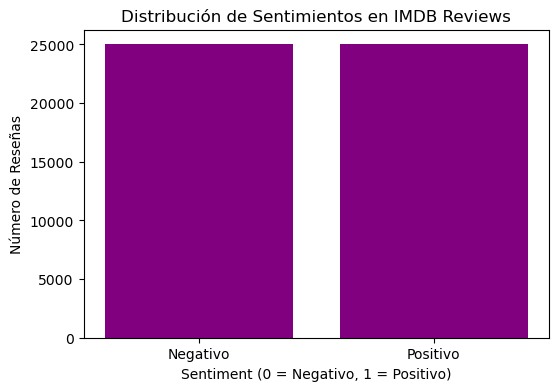

In [15]:
# Visualización de la distribución de "sentiment"
sentiment_counts = full_df["sentiment"].value_counts()
plt.figure(figsize = (6,4))
plt.bar(sentiment_counts.index.astype(str), sentiment_counts.values, color = "purple")
plt.xlabel("Sentiment (0 = Negativo, 1 = Positivo)")
plt.ylabel("Número de Reseñas")
plt.title("Distribución de Sentimientos en IMDB Reviews")
plt.xticks(ticks = [0, 1], labels = ["Negativo", "Positivo"])
plt.show()


In [16]:
full_df['word_count'] = full_df['cleaned_review'].apply(lambda x: len(str(x).split()))
display(full_df.head())


,review,sentiment,cleaned_review,word_count
0,For a movie that gets no respect there sure ar...,1,for a movie that gets no respect there sure ar...,52
1,Bizarre horror movie filled with famous faces ...,1,bizarre horror movie filled with famous faces ...,163
2,"A solid, if unremarkable film. Matthau, as Ein...",1,a solid if unremarkable film matthau as einste...,55
3,It's a strange feeling to sit alone in a theat...,1,its a strange feeling to sit alone in a theate...,422
4,"You probably all already know this by now, but...",1,you probably all already know this by now but ...,141


In [17]:
print(
    'Positivo \n \n',
    full_df[full_df['sentiment'] == 1]['word_count'].describe())


Positivo 
 
 count    25000.000000
mean       227.110680
std        173.195448
min         10.000000
25%        122.000000
50%        168.000000
75%        276.000000
max       2441.000000
Name: word_count, dtype: float64


In [18]:
print(
    'Negativo \n \n',
    full_df[full_df['sentiment'] == 0]['word_count'].describe())


Negativo 
 
 count    25000.000000
mean       223.273000
std        160.422034
min          4.000000
25%        125.000000
50%        170.000000
75%        270.250000
max       1470.000000
Name: word_count, dtype: float64


In [19]:
# Conjuntos de datos positivos y negativos

df_positivo = full_df[full_df['sentiment'] == 1]
df_negativo = full_df[full_df['sentiment'] == 0]


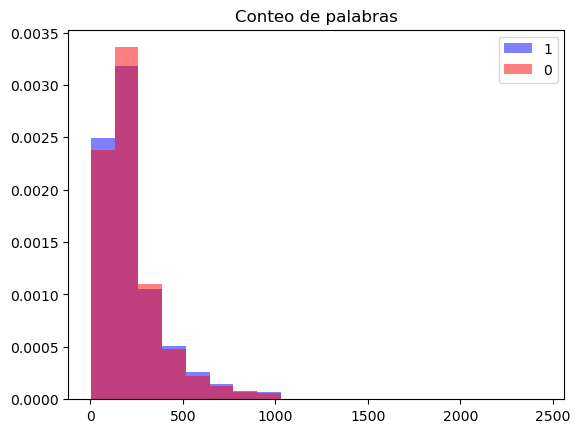

In [20]:
plt.figure()
plt.title('Conteo de palabras')
bins = np.linspace(np.min(full_df['word_count']), np.max(full_df['word_count']), 20)

plt.hist(df_positivo['word_count'],  label = 1, bins = bins, color = 'blue', alpha = 0.5, density = True)
plt.hist(df_negativo['word_count'],  label = 0, bins = bins, color = 'red', alpha = 0.5, density = True)
plt.legend()
plt.show()



## **Vectorización con TF-IDF**

In [22]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(full_df["cleaned_review"], full_df["sentiment"], 
                                                    test_size = 0.2, random_state = 42)


In [23]:
print('Datos de entrenamiento:' , X_train.shape)
print('Datos de validación:' , X_test.shape)


Datos de entrenamiento: (40000,)
Datos de validación: (10000,)


In [24]:

# Vectorización con TF-IDF

tfidf_vectorizer = TfidfVectorizer(max_features = 5000, stop_words = "english")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


## **Comparación de Modelos**

### **Logistic Regression**

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [28]:
# Entrenar el modelo
model = LogisticRegression(max_iter = 1000, random_state = 42)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [29]:
# Predicciones en el conjunto de validación
y_pred = model.predict(X_test_tfidf)


In [30]:
# Evaluación del modelo
print("Reporte de clasificación para Logistic Regression: \n")
print(classification_report(y_test, y_pred))


Reporte de clasificación para Logistic Regression: 

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4945
           1       0.88      0.90      0.89      5055

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [31]:
# Exactitud del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud en el conjunto de validación: {accuracy:.2f}")


Exactitud en el conjunto de validación: 0.89


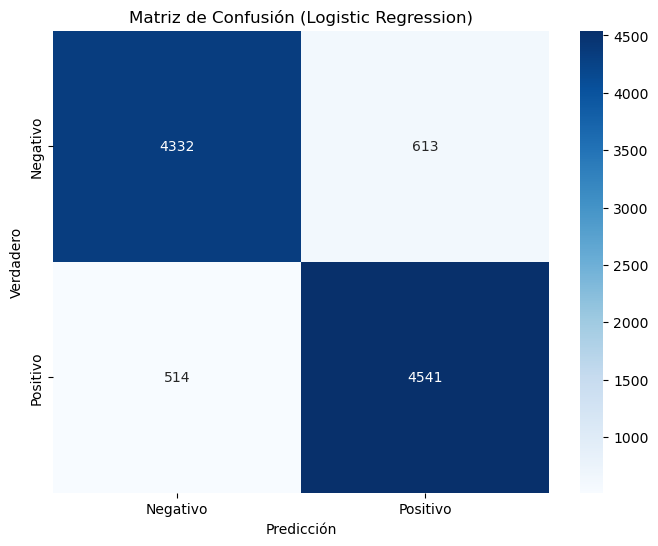

In [32]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = ["Negativo", "Positivo"], yticklabels = ["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión (Logistic Regression)")

if not os.path.exists("imagenes"):
    os.makedirs("imagenes")

plt.savefig("imagenes/matriz_confusion_log_reg.pdf", bbox_inches = "tight")
plt.savefig("imagenes/matriz_confusion_log_reg.png", dpi = 300, bbox_inches = "tight")
plt.show()


### **Support Vector Machines (SVM)**

In [34]:
from sklearn.svm import SVC

In [35]:
# Entrenar el modelo SVM
svm_model = SVC(kernel = "linear", random_state = 42)
svm_model.fit(X_train_tfidf, y_train)


SVC(kernel='linear', random_state=42)

In [36]:
# Predicciones en el conjunto de validación
y_pred_svm = svm_model.predict(X_test_tfidf)


In [37]:
# Evaluación del modelo
print("Reporte de clasificación para SVM: \n")
print(classification_report(y_test, y_pred_svm))


Reporte de clasificación para SVM: 

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4945
           1       0.88      0.89      0.89      5055

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [38]:
# Exactitud del modelo
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Exactitud en el conjunto de validación con SVM: {accuracy_svm:.2f}")


Exactitud en el conjunto de validación con SVM: 0.88


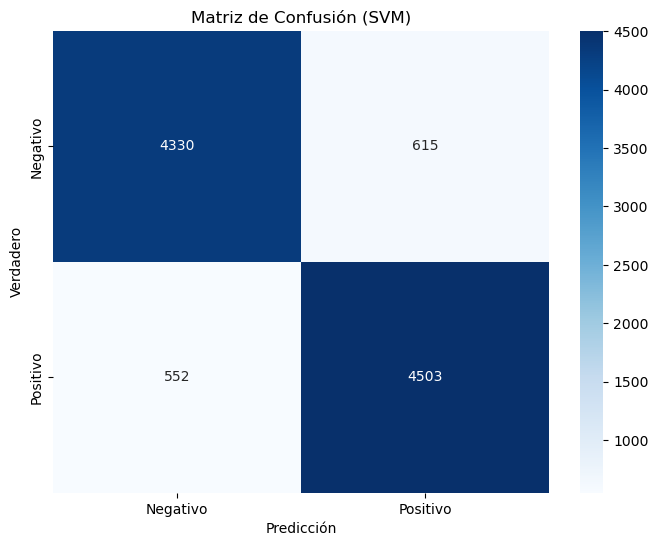

In [39]:
# Matriz de confusión
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix_svm, annot = True, fmt  ='d', cmap = 'Blues',
            xticklabels = ["Negativo", "Positivo"], yticklabels = ["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión (SVM)")

if not os.path.exists("imagenes"):
    os.makedirs("imagenes")

plt.savefig("imagenes/matriz_confusion_svm.pdf", bbox_inches = "tight")
plt.savefig("imagenes/matriz_confusion_svm.png", dpi = 300, bbox_inches = "tight")
plt.show()



### **Random Forest**

In [41]:
from sklearn.ensemble import RandomForestClassifier


In [42]:
# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model.fit(X_train_tfidf, y_train)


RandomForestClassifier(random_state=42)

In [43]:
# Predicciones en el conjunto de validación
y_pred_rf = rf_model.predict(X_test_tfidf)


In [44]:
# Evaluación del modelo
print("Reporte de clasificación para Random Forest: \n")
print(classification_report(y_test, y_pred_rf))


Reporte de clasificación para Random Forest: 

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      4945
           1       0.85      0.83      0.84      5055

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [45]:
# Exactitud del modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Exactitud en el conjunto de validación con Random Forest: {accuracy_rf:.2f}")


Exactitud en el conjunto de validación con Random Forest: 0.84


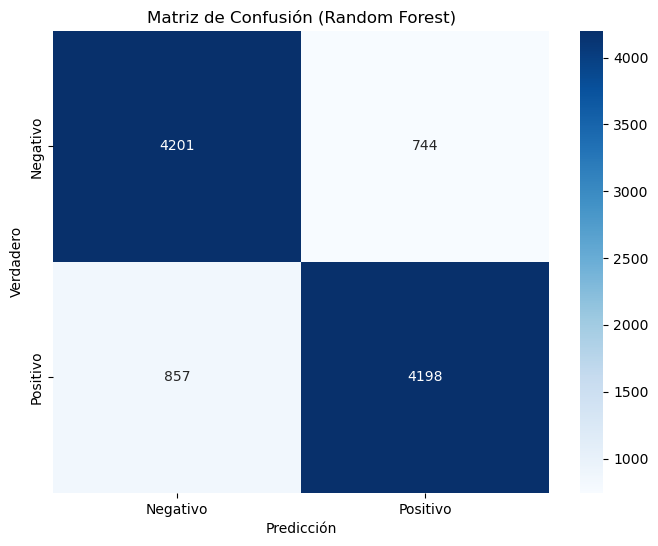

In [46]:
# Matriz de confusión
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix_rf, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = ["Negativo", "Positivo"], yticklabels = ["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión (Random Forest)")

if not os.path.exists("imagenes"):
    os.makedirs("imagenes")

plt.savefig("imagenes/matriz_confusion_ran_for.pdf", bbox_inches = "tight")
plt.savefig("imagenes/matriz_confusion_ran_for.png", dpi = 300, bbox_inches = "tight")
plt.show()


### **Neural Network**

In [48]:
from sklearn.neural_network import MLPClassifier

In [49]:
# Entrenar el modelo Random Forest
nn_model = MLPClassifier(max_iter = 300)
nn_model.fit(X_train_tfidf, y_train)


MLPClassifier(max_iter=300)

In [50]:
# Predicciones en el conjunto de validación
y_pred_nn = nn_model.predict(X_test_tfidf)


In [51]:
# Evaluación del modelo
print("Reporte de clasificación para Neural Network: \n")
print(classification_report(y_test, y_pred_nn))


Reporte de clasificación para Neural Network: 

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      4945
           1       0.87      0.86      0.86      5055

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [52]:
# Exactitud del modelo
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Exactitud en el conjunto de validación con Neural Network: {accuracy_nn:.2f}")


Exactitud en el conjunto de validación con Neural Network: 0.86


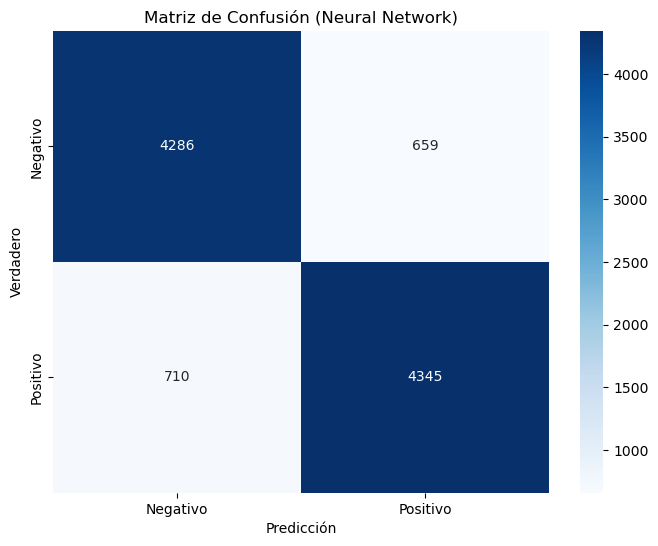

In [53]:
# Matriz de confusión
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix_nn, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = ["Negativo", "Positivo"], yticklabels = ["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión (Neural Network)")

if not os.path.exists("imagenes"):
    os.makedirs("imagenes")

plt.savefig("imagenes/matriz_confusion_neural.pdf", bbox_inches = "tight")
plt.savefig("imagenes/matriz_confusion_neural.png", dpi = 300, bbox_inches = "tight")
plt.show()


### **Comparar resultados**

In [55]:
# Crear un DataFrame para comparar exactitudes
results = {
    "Modelo": ["Logistic Regression", "SVM", "Random Forest", "Neural Network"],
    "Exactitud": [accuracy, accuracy_svm, accuracy_rf, accuracy_nn],
}


In [56]:
results_df = pd.DataFrame(results)

# Mostrar tabla de resultados
print("Comparación de Resultados: \n")
print(results_df)


Comparación de Resultados: 

                Modelo  Exactitud
0  Logistic Regression     0.8873
1                  SVM     0.8833
2        Random Forest     0.8399
3       Neural Network     0.8631


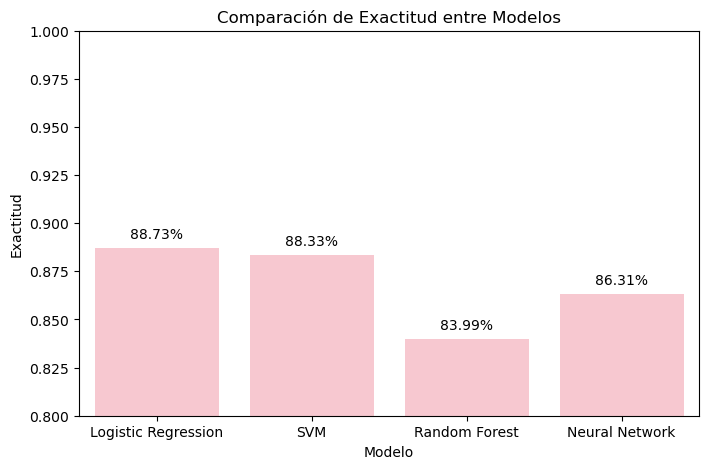

In [57]:
# Gráfica de comparación
plt.figure(figsize = (8, 5))
sns.barplot(x = "Modelo", y = "Exactitud", data = results_df, color = "pink")
plt.title("Comparación de Exactitud entre Modelos")
plt.ylabel("Exactitud")
plt.xlabel("Modelo")
plt.ylim(0.8, 1)  

# Agregar etiquetas de valores en las barras
for index, row in results_df.iterrows():
    plt.text(index, row["Exactitud"] + 0.005, f'{row["Exactitud"]*100:.2f}%', ha = 'center', fontsize = 10)

if not os.path.exists("imagenes"):
    os.makedirs("imagenes")

plt.savefig("imagenes/Comparacion_Modelos.pdf", bbox_inches = "tight")
plt.savefig("imagenes/Comparacion_Modelos.png", dpi = 300, bbox_inches = "tight")
plt.show()
